In [1]:
import pandas as pd
import random
import numpy as np
from matplotlib import pylab as plt
import scipy.stats
import copy
from scipy.sparse import linalg as LA
#import powerlaw
# %matplotlib inline

path_data = "../data/"
path_fig = "../results/fig/"
# cps file name
file_asec = "cpsasec_00001.csv"
# file_occ_soc_map = "2010-occ-codes-soc-categories_clean.csv"
# used for CPS is "occ2010_in_cps2019.csv"
file_occ_in_cps2010 = "occ2010_cps_broad_class.csv"
# pkl file for asec
file_asec_pkl = "CPS_asec_df_occmob_summary.pkl"

In [2]:
df_categories = pd.read_csv(path_data + file_occ_in_cps2010 )
df_categories.head()

,Code,BroadClassification,Label
0,10,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",Chief executives and legislators/public admini...
1,20,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",General and Operations Managers
2,30,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers in Marketing, Advertising, and Public..."
3,100,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",Administrative Services Managers
4,110,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",Computer and Information Systems Managers


In [3]:
df_categories = pd.read_csv(path_data + file_occ_in_cps2010)
df_categories.head()
occ_names = list(df_categories["Label"])
occ_codes = list(df_categories["Code"])
dict_code_index = {}
for i in range(len(occ_codes)):
    dict_code_index[occ_codes[i]] = i

In [4]:
df_asec = pd.read_pickle(path_data + file_asec_pkl)
df_asec_2019 = pd.read_pickle(path_data + "CPS_asec_df_occmob_summary_2019.pkl")

In [5]:
len(df_categories)

458

### quick check asec and asec 2019

In [6]:
df_asec = df_asec[df_asec["ASECWT"].notna()]
# remove CPSIDP unless they are part of the asec over sample
df_asec = df_asec[(df_asec["CPSIDP"] != 0) | (df_asec["ASECOVERP"] == 1)] 
# Drop 2021
df_asec = df_asec[df_asec["YEAR"] != 2021]
# same for 2019
df_asec_2019 = df_asec_2019[df_asec_2019["ASECWT"].notna()]
# remove CPSIDP unless they are part of the asec over sample
df_asec_2019 = df_asec_2019[(df_asec_2019["CPSIDP"] != 0) | (df_asec_2019["ASECOVERP"] == 1)] 

In [7]:
df_asec_2019_v2 = df_asec[df_asec["YEAR"] == 2019]

In [8]:
df_asec_2019["ChangeOcc"] = df_asec_2019["OCC2010"] != df_asec_2019["OCC10LY"]
df_asec_2019["ChangeOccWT"] = df_asec_2019["ChangeOcc"] * df_asec_2019["ASECWT"]

In [9]:
print("Workforce estimation (millions) ", df_asec_2019["ASECWT"].sum()/1e6)
print("People that changed occupaiton (millions) ", df_asec_2019["ChangeOccWT"].sum()/1e6)
print("Percentage of workforce that switched occupation in a year ", df_asec_2019["ChangeOccWT"].sum()/df_asec_2019["ASECWT"].sum())

Workforce estimation (millions)  163.00103038999998
People that changed occupaiton (millions)  25.82486389
Percentage of workforce that switched occupation in a year  0.15843374626657783


In [10]:
df_asec_2019_v2["ChangeOcc"] = df_asec_2019_v2["OCC2010"] != df_asec_2019_v2["OCC10LY"]
df_asec_2019_v2["ChangeOccWT"] = df_asec_2019_v2["ChangeOcc"] * df_asec_2019_v2["ASECWT"]

<ipython-input-10-d34464c58ae6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asec_2019_v2["ChangeOcc"] = df_asec_2019_v2["OCC2010"] != df_asec_2019_v2["OCC10LY"]
<ipython-input-10-d34464c58ae6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asec_2019_v2["ChangeOccWT"] = df_asec_2019_v2["ChangeOcc"] * df_asec_2019_v2["ASECWT"]


**note the lines before count transitions from unemployed, military, etc.**

In [11]:
print("Workforce estimation (millions) ", df_asec_2019_v2["ASECWT"].sum()/1e6)
print("People that changed occupaiton (millions) ", df_asec_2019_v2["ChangeOccWT"].sum()/1e6)
print("Percentage of workforce that switched occupation in a year ", df_asec_2019_v2["ChangeOccWT"].sum()/df_asec_2019_v2["ASECWT"].sum())

Workforce estimation (millions)  163.00103038999998
People that changed occupaiton (millions)  25.82486389
Percentage of workforce that switched occupation in a year  0.15843374626657783


### close check

In [12]:
df_asec = df_asec[df_asec["ASECWT"].notna()]
# remove CPSIDP unless they are part of the asec over sample
df_asec = df_asec[(df_asec["CPSIDP"] != 0) | (df_asec["ASECOVERP"] == 1)] 
# Drop 2021
df_asec = df_asec[df_asec["YEAR"] != 2021]

In [13]:
df_asec = df_asec[(df_asec["ASECWT"].notna()) & (df_asec["OCC2010"] != 9999) & (df_asec["OCC10LY"] != 9999)\
                 & (df_asec["OCC2010"] != 9920) & (df_asec["OCC10LY"] != 9920)] 

In [14]:
occ_asec = set(df_asec["OCC2010"].unique())
occ_cps_form = set(df_categories["Code"])

In [15]:
print("in ASEC but not in the other list", occ_asec.difference(occ_cps_form))
print("in list but not ASEC", occ_cps_form.difference(occ_asec))
#NOTE this is other way around than in CPS, should probably check list again
to_remove_list = occ_cps_form.difference(occ_asec)
to_remove_asec = occ_asec.difference(occ_cps_form)
df_categories = df_categories[~df_categories['Code'].isin(to_remove_list)]
df_asec = df_asec[~df_asec['OCC2010'].isin(to_remove_asec)]
df_asec = df_asec[~df_asec['OCC10LY'].isin(to_remove_asec)]

in ASEC but not in the other list set()
in list but not ASEC {9920, 9800, 1980, 9810, 9820}


In [35]:
to_remove_list

{1980, 9800, 9810, 9820, 9920}

In [36]:
to_remove_asec

set()

In [16]:
df_asec.columns

Index(['YEAR', 'SERIAL', 'MONTH', 'CPSID', 'ASECFLAG', 'HFLAG', 'CPSIDP',
       'ASECWT', 'AGE', 'SEX', 'RACE', 'HISPAN', 'EMPSTAT', 'LABFORCE', 'OCC',
       'OCC2010', 'IND', 'EMPSAME', 'ASECOVERP', 'OCCLY', 'OCC10LY', 'QOCCLY'],
      dtype='object')

In [17]:
years = df_asec["YEAR"].unique()
n_years = len(years)

In [18]:
print( "Average employed 2000-2020 using ASECWT (million workers)", df_asec["ASECWT"].sum()/(1e6*n_years))

Average employed 2000-2020 using ASECWT (million workers) 153.15937275714285


In [19]:
df_asec_2010_2019 = df_asec[df_asec["YEAR"].isin([i for i in range(2010, 2020)])]

In [20]:
df_asec_2010_2019["ChangeOcc"] = df_asec_2010_2019["OCC2010"] != df_asec_2010_2019["OCC10LY"]
df_asec_2010_2019["ChangeOccWT"] = df_asec_2010_2019["ChangeOcc"] * df_asec_2010_2019["ASECWT"]

<ipython-input-20-0fcd7a9e9faa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asec_2010_2019["ChangeOcc"] = df_asec_2010_2019["OCC2010"] != df_asec_2010_2019["OCC10LY"]
<ipython-input-20-0fcd7a9e9faa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asec_2010_2019["ChangeOccWT"] = df_asec_2010_2019["ChangeOcc"] * df_asec_2010_2019["ASECWT"]


In [21]:
print("Workforce estimation (millions) ", df_asec_2010_2019["ASECWT"].sum()/1e6)
print("People that changed occupaiton (millions) ", df_asec_2010_2019["ChangeOccWT"].sum()/1e6)
print("Percentage of workforce that switched occupation in a year ", df_asec_2010_2019["ChangeOccWT"].sum()/df_asec_2010_2019["ASECWT"].sum())

Workforce estimation (millions)  1637.91351948
People that changed occupaiton (millions)  176.50899297000004
Percentage of workforce that switched occupation in a year  0.10776453754776845


In [22]:
def occ_mob_asec(df, dict_code_index, norm):
    """Makes occupational mobiltiy network from ASEC
    """
    # make empty matrix
    n = len(dict_code_index)
    A = np.zeros([n, n])
    # fill whenver there is a transition
    for index, row in df.iterrows():
        if row["OCC2010"] != row["OCC10LY"]:
            i, j = dict_code_index[(row["OCC10LY"])], dict_code_index[row["OCC2010"]]
            A[i, j] += row["ASECWT"]/norm # consider ASEC weights
    
    return A

In [23]:
T_asec = occ_mob_asec(df_asec, dict_code_index, norm=len([i for i in range(2000, 2021)]))

In [24]:
T_asec_2010_2019 = occ_mob_asec(df_asec_2010_2019, dict_code_index, norm=len([i for i in range(2010, 2020)]))
print("Mean share of population transitioning 2010-2019 ", T_asec_2010_2019.sum()/df_asec_2010_2019["ASECWT"].sum())

Mean share of population transitioning 2010-2019  0.010776453754776847


In [25]:
print("Mean share of population transitioning 2010-2019 ", T_asec_2010_2019.sum()/df_asec_2010_2019["ASECWT"].sum())

Mean share of population transitioning 2010-2019  0.010776453754776847


In [26]:
for y in range(2010,2020):
    df_asec_year = df_asec[df_asec["YEAR"] == y]
    T = occ_mob_asec(df_asec_year, dict_code_index, norm=1)
    print(T.sum(), df_asec_year["ASECWT"].sum())
    print("Mean share of population transitioning ", y, T.sum()/df_asec_year["ASECWT"].sum())

12074171.959999999 143884187.69
Mean share of population transitioning  2010 0.08391590593689092
12910832.840000004 142915509.42999998
Mean share of population transitioning  2011 0.09033892046771684
13071923.609999998 144156608.02999997
Mean share of population transitioning  2012 0.09067862922579062
13855691.859999998 145637195.69
Mean share of population transitioning  2013 0.09513841429282191
32572014.770000003 294653613.66999996
Mean share of population transitioning  2014 0.11054340845953219
16668051.44 148903539.27
Mean share of population transitioning  2015 0.11193858468183607
18095611.6 152218548.07999998
Mean share of population transitioning  2016 0.11887914993440662
17221669.389999997 153486996.5
Mean share of population transitioning  2017 0.11220279100321047
20062647.090000007 155450422.95000002
Mean share of population transitioning  2018 0.12906138632027445
19976378.409999993 156606898.17
Mean share of population transitioning  2019 0.12755746166631324


In [29]:
print(len(dict_code_index))
print(T_asec_2010_2019.shape)

458
(458, 458)


In [ ]:
np.savetxt(path_data + "asec_00_20_avg_occ2010.csv", T_asec, delimiter=",")
np.savetxt(path_data + "asec_10_19_avg_occ2010.csv", T_asec_2010_2019, delimiter=",")

In [151]:
np.where(T_asec_2010_2019.sum(axis=1) == 0)

(array([ 91, 327, 433, 453, 454, 455, 457]),)

In [34]:
len(df_categories)

453

In [172]:
df_categories.tail()

,Code,BroadClassification,Label
449,9640,TRANSPORTATION AND MATERIAL MOVING,"Packers and Packagers, Hand"
450,9650,TRANSPORTATION AND MATERIAL MOVING,Pumping Station Operators
451,9720,TRANSPORTATION AND MATERIAL MOVING,Refuse and Recyclable Material Collectors
452,9750,TRANSPORTATION AND MATERIAL MOVING,"Material moving workers, nec"
456,9830,TRANSPORTATION AND MATERIAL MOVING,"Military, Rank Not Specified"


In [74]:
df_categories.to_csv(path_data + "occ_names_class_asec_occ2010.csv", index=False)

## Add employment

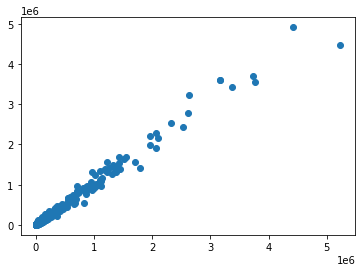

In [30]:
df_asec_2019 = df_asec_2010_2019[df_asec_2010_2019["YEAR"] == 2019]
dict_occ_emp_2019 = {}
dict_occ_emp_2010_2019 = {}
for index, row in df_categories.iterrows():
    #dict_occ_emp[row["Code"]] = 0
    dict_occ_emp_2019[row["Code"]] = 0
    dict_occ_emp_2010_2019[row["Code"]] = 0
    
for index, row in df_asec_2019.iterrows():
    dict_occ_emp_2019[row["OCC2010"]] += row["ASECWT"]
    
for index, row in df_asec_2010_2019.iterrows():
    dict_occ_emp_2010_2019[row["OCC2010"]] += row["ASECWT"]/10
    
df_categories["EMP_2019"] = df_categories["Code"].map(dict_occ_emp_2019)
df_categories["EMP_2010_2019_avg"] = df_categories["Code"].map(dict_occ_emp_2010_2019)

df_categories.to_csv(path_data + "occ_names_employment_asec_occ2010.csv", index=False)

plt.scatter(df_categories["EMP_2019"], df_categories["EMP_2010_2019_avg"])
plt.show()

In [33]:
len(dict_occ_emp_2019)

453

In [32]:
len(dict_occ_emp_2010_2019)

453

### same but now use occ2010 instead of occ

In [175]:
def occ_mob_asec_occ(df, dict_code_index, norm):
    """Makes occupational mobiltiy network from ASEC
    """
    # make empty matrix
    n = len(dict_code_index)
    A = np.zeros([n, n])
    # fill whenver there is a transition
    for index, row in df.iterrows():
        if row["OCC"] != row["OCCLY"]:
            i, j = dict_code_index[(row["OCCLY"])], dict_code_index[row["OCC"]]
            A[i, j] += row["ASECWT"]/norm # consider ASEC weights
    
    return A

In [176]:
file_occ_in_cps2011_2019 = "occ_names_code_2011-2019.csv"

In [177]:
occ_names = list(df_occ["Label"])
occ_codes = list(df_occ["Code"])
dict_code_index = {}
for i in range(len(occ_codes)):
    dict_code_index[occ_codes[i]] = i

In [189]:
df_occ = pd.read_csv(path_data + file_occ_in_cps2011_2019  )
df_occ.head()

,Code,Label
0,10,Chief executives
1,20,General and operations managers
2,30,Legislators
3,40,Advertising and promotions managers
4,50,Marketing and sales managers


In [190]:
df_asec = pd.read_pickle(path_data + file_asec_pkl)
df_asec = df_asec[df_asec["ASECWT"].notna()]
# remove CPSIDP unless they are part of the asec over sample
df_asec = df_asec[(df_asec["CPSIDP"] != 0) | (df_asec["ASECOVERP"] == 1)] 
# Drop 2021
df_asec = df_asec[df_asec["YEAR"] != 2021]

In [191]:
df_asec = df_asec[(df_asec["ASECWT"].notna()) & (df_asec["OCC"] != 9999) & (df_asec["OCCLY"] != 9999)\
                 & (df_asec["OCC"] != 9920) & (df_asec["OCCLY"] != 9920)] 

In [192]:
df_asec_2011_2019 = df_asec[df_asec["YEAR"].isin([i for i in range(2011, 2020)])]

In [193]:
occ_asec = set(df_asec_2011_2019["OCC"].unique())
occ_cps_form = set(df_occ["Code"])

In [194]:
print("in ASEC but not in external list", occ_asec.difference(occ_cps_form))
print("in external list but not ASEC", occ_cps_form.difference(occ_asec))
#NOTE this is other way around than in CPS, should probably check list again
to_remove_list = occ_cps_form.difference(occ_asec)
to_remove_asec = occ_asec.difference(occ_cps_form)
df_occ = df_occ[~df_occ['Code'].isin(to_remove_list)]
df_asec = df_asec[~df_asec['OCC'].isin(to_remove_asec)]
df_asec = df_asec[~df_asec['OCCLY'].isin(to_remove_asec)]

in ASEC but not in external list {0}
in external list but not ASEC {6410, 7820, 6030, 400, 4630, 920, 6810, 30, 9250, 550, 2730, 4910, 8110, 6450, 1850, 2110, 7230, 1730, 6340, 4550, 8520, 3020, 7250, 4310, 1750, 610, 3810, 7910, 1000, 9320, 4330, 7530, 2030, 8050, 8820, 4730}


In [195]:
df_asec_2011_2019["ChangeOcc"] = df_asec_2011_2019["OCC"] != df_asec_2011_2019["OCCLY"]
df_asec_2011_2019["ChangeOccWT"] = df_asec_2011_2019["ChangeOcc"] * df_asec_2011_2019["ASECWT"]

In [196]:
T_asec_2011_2019 = occ_mob_asec_occ(df_asec_2011_2019, dict_code_index, norm=len([i for i in range(2011, 2020)]))
print("Mean share of population transitioning 2011-2019 ", T_asec_2011_2019.sum()/df_asec_2011_2019["ASECWT"].sum())

Mean share of population transitioning 2011-2019  0.016899090276004176


In [197]:
np.where(T_asec_2011_2019.sum(axis=1) == 0)

(array([ 69,  98, 105, 107, 114, 115, 158, 174, 214, 322, 336, 347, 375,
        377, 409, 413, 441, 444, 445, 458, 462, 463, 486, 506, 511, 512,
        518, 529]),)

In [198]:
T_asec_2011_2019.shape

(533, 533)

In [ ]:
np.savetxt(path_data + "asec_11_19_avg_occ.csv", T_asec_2011_2019, delimiter=",")

In [186]:
0 in to_remove_list

False

In [184]:
df_occ

,Code,Label
0,0,Not in universe
1,10,Chief executives
2,20,General and operations managers
4,40,Advertising and promotions managers
5,50,Marketing and sales managers
...,...,...
564,9720,Refuse and recyclable material collectors
565,9730,Shuttle car operators
566,9740,Tank car truck and ship loaders
567,9750,Material moving workers all other


## Get employment

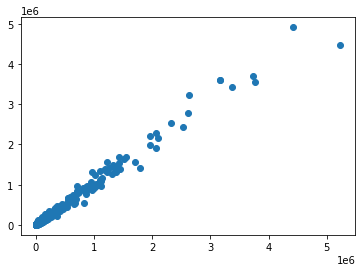